In [84]:
import os
import re
import pandas as pd
import json

POSITIVE_DIR = 'data/positive/'
NEGATIVE_DIR = 'data/negative/'
REGEX_TO_REPLACE = 'sketch.js:45 poseJSON:  |poseJSON:  '

## Load data

Load JSON files generated with PoseNet. 

In [85]:
def load_files(dir_name):
    df = pd.DataFrame()
    files = [f for f in os.listdir(dir_name) if f.endswith('.log') or f.endswith('.json')]
    for f in files:
        with open(dir_name + f) as content:
            data = content.read()
            if re.search(REGEX_TO_REPLACE, data):
                data = re.sub(REGEX_TO_REPLACE, ",", data)
                
                if data.endswith('\n'):
                    data = data[1:-1]
                else:
                    data = data[1:]
                data = '[{}]'.format(data)
     
            data = json.loads(data)
            
            for value in data:
                df_aux = {}
                for scores in value:
                    part = scores['part']
                    df_aux['score_' + part] = scores['score']
                    df_aux['position_x_' + part] = scores['position']['x']
                    df_aux['position_y_' + part] = scores['position']['y']
                df = df.append(df_aux, ignore_index=True)
    return df

In [86]:
df_positive = load_files(POSITIVE_DIR)
df_negative = load_files(NEGATIVE_DIR)
df_positive['class'] = 1
df_negative['class'] = 0
print('Positive:', df_positive.shape)
print('Negative:', df_negative.shape)
df = df_positive.append(df_negative)

Positive: (171, 52)
Negative: (126, 52)


In [95]:
df.dropna(inplace=True)

## Separate between target variable and predictors

In [96]:
X = df.drop('class', axis=1)
y = df['class']

## Divide into train/test sets

In [97]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=20, shuffle=True)

In [98]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=5, random_state = 123)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
score = rf_model.score(X_test, y_test)
print('Score:', score)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != predictions).sum()))

Score: 0.85
Number of mislabeled points out of a total 60 points : 9


## Confusion Matrix

In [99]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('True positive:',tn, ', False positive:',fp, ', False negative:',fn, ', True positive:',tp)
confusion_matrix(y_test, predictions)

True positive: 20 , False positive: 6 , False negative: 3 , True positive: 31


array([[20,  6],
       [ 3, 31]])

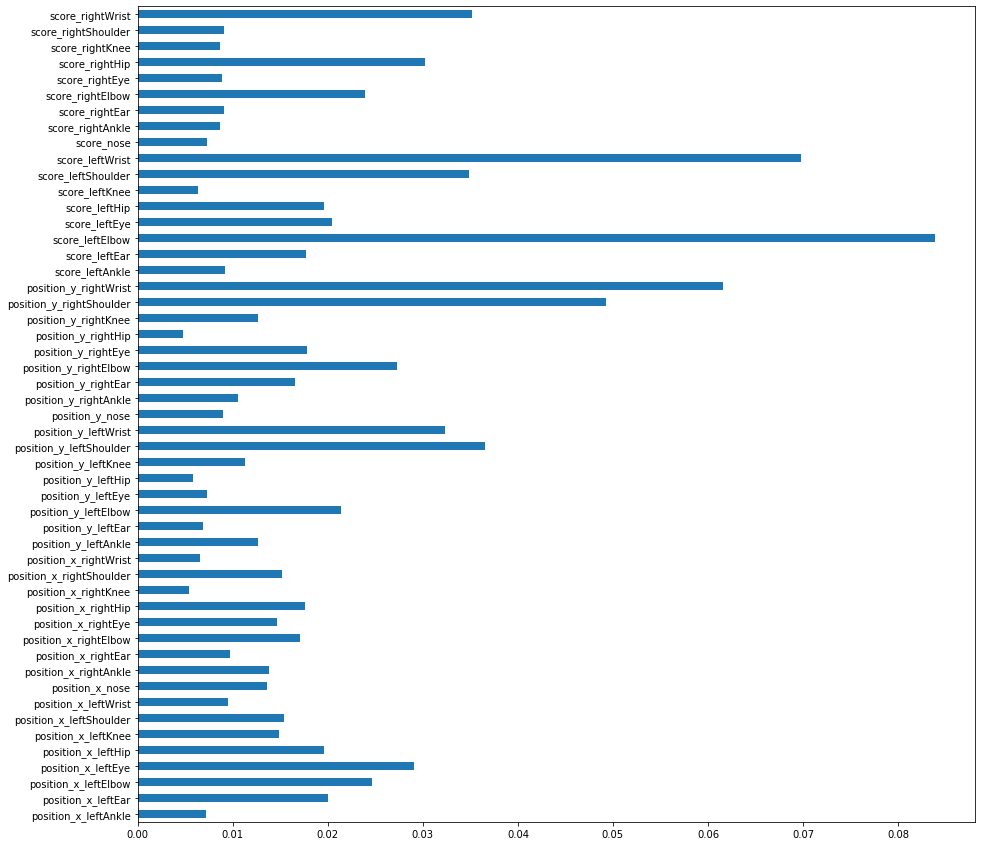

In [100]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
fig, ax = plt.subplots(1,1, figsize=(15, 15))
feat_importances.plot(kind='barh', ax=ax)
plt.show()

## Cross Validation


In [101]:
from sklearn.model_selection import cross_val_score
rfc_cv_score = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='roc_auc')
rfc_cv_score.mean()

0.9214835164835165

## Load model

In [102]:
from joblib import dump, load
dump(rf_model, 'model.joblib') 

['model.joblib']

In [103]:
clf = load('model.joblib')

In [104]:
to_predict = df.drop('class', axis=1)

In [105]:
X_test.shape

(60, 51)

In [106]:
clf.predict(to_predict.values)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0])